In [1]:
import sys
import os
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
import plot.viz_sequence as viz_sequence
import model.train_profile_model as train_profile_model
import model.profile_models as profile_models
import extract.compute_shap as compute_shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pyBigWig
from pyfaidx import Fasta
import numpy as np
import scipy.stats
import h5py
import tqdm
tqdm.tqdm_notebook(range(1))

Using TensorFlow backend.
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/u

  0%|<bar/>| 0/1 [00:00<?, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


### Define constants and paths

In [3]:
base_path = "/users/amtseng/tfmodisco/results/misc_results/bam_reads"

e2f6_reads_at_max_hits_path = os.path.join(base_path, "E2F6_reads_at_MAX_hits.tsv")
max_reads_at_max_hits_path = os.path.join(base_path, "MAX_reads_at_MAX_hits.tsv")
max_reads_at_e2f6_hits_path = os.path.join(base_path, "MAX_reads_at_E2F6_hits.tsv")
e2f6_reads_at_e2f6_hits_path = os.path.join(base_path, "E2F6_reads_at_E2F6_hits.tsv")

In [4]:
model_base_path = "/srv/scratch/amtseng/tfmodisco/results/best_models_bigwigs/models"

e2f6_model_path = os.path.join(model_base_path, "E2F6_task0_model.h5")
max_model_path = os.path.join(model_base_path, "MAX_task0_model.h5")

bigwig_base_path = "/srv/scratch/amtseng/tfmodisco/results/best_models_bigwigs/profiles"

e2f6_bigwig_paths = [os.path.join(bigwig_base_path, "E2F6_task0_true_profile_%s.bw" % strand) for strand in ("neg", "pos")]
max_bigwig_paths = [os.path.join(bigwig_base_path, "MAX_task0_true_profile_%s.bw" % strand) for strand in ("neg", "pos")]

In [5]:
input_length = 2114
profile_length = 1000

In [6]:
reference_genome_path = "/users/amtseng/genomes/hg38.fasta"
reference_genome_reader = Fasta(reference_genome_path, "r")

In [7]:
# Import models
e2f6_model = train_profile_model.load_model(e2f6_model_path, 1, profile_length)
max_model = train_profile_model.load_model(max_model_path, 1, profile_length)







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# Create explainers
e2f6_explainer = compute_shap.create_profile_model_count_explainer(e2f6_model)
max_explainer = compute_shap.create_profile_model_count_explainer(max_model)

In [9]:
out_path = "/users/amtseng/tfmodisco/figures/allele_specific_binding/"
os.makedirs(out_path, exist_ok=True)

### Helper functions

In [10]:
def get_genomic_sequence(chrom, start, end):
    """
    Gets sequence at the given coordinate.
    """
    return reference_genome_reader[chrom][start:end].seq.upper()

In [11]:
def dna_to_one_hot(seqs, out_dtype=np.float64):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    `out_dtype` can be altered to change the datatype of the output one-hot
    sequences. By default, this is `np.float64`, but may be changed to other
    types (e.g. using `out_dtype=np.int8` will drastically reduce memory usage).
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper() + "ACGT"
    # Add one example of each base, so np.unique doesn't miss indices later

    one_hot_map = np.identity(5)[:, :-1].astype(out_dtype)

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))

In [12]:
revcomp_dict = str.maketrans("ACGT", "TGCA")

def revcomp_seq(seq):
    return seq.translate(revcomp_dict)[::-1]

In [13]:
def import_allele_count_dicts(
    hit_reads_path, allele_extract_func=None, required_alleles=None, min_alleles=1
):
    """
    Imports the set of read alleles at each position specified in the given file.
    Note that an "allele" here is a subsequence of a read at a given position.
    Arguments:
        `hit_reads_path`: path to TSV mapping coordinates to set of read alleles,
            output by `extract_motif_reads.py`
        `allele_extract_func`: if given, this is a function which maps an allele
            (i.e. a substring of a read) to another substring (e.g. a shorter
            window) for consideration; all alleles will be flipped to the positive
            strand orientation before applying this function
        `required_alleles`: a list of strings; if given, only retain positions
            which have at least one of each of these alleles; alleles will be
            flipped to the positive strand orientation for this check
        `min_alleles`: if given, only retain positions which have at least this
            many alleles; defaults to 1
    Returns an N x 3 array of coordinates and a parallel array containing
    dictionaries, where each dictionary maps an allele to the count of how many
    times it was seen at that position.
    """
    coords, allele_count_dicts = [], []

    with open(hit_reads_path, "r") as f:
        for line in tqdm.notebook.tqdm(f):
            tokens = line.strip().split("\t")
            coord = (tokens[0], int(tokens[1]), int(tokens[2]))
            strand = tokens[3]
            seqs = tokens[4].split(",")
            
            # For simplicity, filter out anything with gaps
            seqs = [seq for seq in seqs if "-" not in seq]
            
            # Flip everything, if needed
            if strand == "-":
                seqs = [revcomp_seq(seq) for seq in seqs]

            # Limit to the specified window
            if allele_extract_func:
                seqs = [allele_extract_func(seq) for seq in seqs]

            alleles, counts = np.unique(seqs, return_counts=True)
            count_dict = dict(zip(alleles, counts))

            # Require at least `min_alleles` allele
            if len(alleles) < min_alleles:
                continue

            # Require the required motif to be represented
            if required_alleles and not all(allele in alleles for allele in required_alleles):
                continue

            coords.append(coord)
            allele_count_dicts.append(count_dict)
    
    coords_arr = np.empty((len(coords), 3), dtype=object)
    for i, (chrom, start, end) in enumerate(coords):
        coords_arr[i, 0] = chrom
        coords_arr[i, 1] = start
        coords_arr[i, 2] = end
    return coords_arr, allele_count_dicts

In [14]:
def plot_allele_count_stats(allele_count_dicts):
    """
    Given a list of allele count dictionaries, plots a few figures to
    examine the counts distributions, including:
    1. Scatterplot of top count vs the 2nd top count
    2. Bar plot of which alleles are most common
    """
    # Plot the top vs 2nd-most prevalent allele counts
    top_allele_counts = np.zeros((len(allele_count_dicts), 2))
    for i, d in enumerate(allele_count_dicts):
        counts = sorted(d.values())
        top_allele_counts[i, 0] = counts[-1]
        top_allele_counts[i, 1] = counts[-2]

    top_counts = np.log10(top_allele_counts)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(top_counts[:, 0], top_counts[:, 1], alpha=0.1)

    (min_x, max_x), (min_y, max_y) = ax.get_xlim(), ax.get_ylim()
    min_both, max_both = min(min_x, min_y), max(max_x, max_y)
    ax.set_xlim(min_both, max_both)
    ax.set_ylim(min_both, max_both)
    ax.plot(
        [min_both, max_both], [min_both, max_both],
        color="black", linestyle="--", alpha=0.3, zorder=0
    )

    ax.set_xlabel("Most common allele")
    ax.set_ylabel("2nd most common allele")
    plt.show()

    # Count how often the most common allele is each allele
    counts = {}
    for d in allele_count_dicts:
        max_allele = sorted(d.keys(), key=lambda k: -d[k])[0]
        try:
            counts[max_allele] += 1
        except KeyError:
            counts[max_allele] = 1

    fig, ax = plt.subplots(figsize=(20, 8))
    labels = sorted(counts.keys(), key=lambda k:-counts[k])
    heights = [counts[key] for key in labels]
    ax.bar(labels, heights, 1)
    ax.set_xticklabels(labels, rotation=90)
    plt.show()

In [15]:
def plot_true_profiles(
    chrom, start, end, bigwig_paths, prof_interval=(-350, 350), save_path=None
):
    """
    For a given region, plots the true/predicted profiles and importance scores.
    """
    mid = (start + end) // 2
    prof_start = mid + prof_interval[0]
    prof_end = mid + prof_interval[1]
    
    neg_bigwig_path, pos_bigwig_path = bigwig_paths
    neg_bigwig = pyBigWig.open(neg_bigwig_path, "r")
    pos_bigwig = pyBigWig.open(pos_bigwig_path, "r")

    neg_prof = np.nan_to_num(neg_bigwig.values(chrom, prof_start, prof_end))
    pos_prof = np.nan_to_num(pos_bigwig.values(chrom, prof_start, prof_end))
    
    neg_bigwig.close()
    pos_bigwig.close()
    
    prof_fig, ax = plt.subplots(figsize=(20, 3))
    # Draw profiles
    ax.plot(neg_prof, color="darkslateblue")
    ax.plot(-pos_prof, color="darkorange")
    ax.set_title("True ChIP-seq profiles")
    
    if save_path:
        plt.savefig(
            os.path.join(save_path + "_true_profiles.svg"), format="svg"
        )
    plt.show()

In [16]:
def plot_predictions_imp_scores(
    input_seqs, model, explainer, prof_interval=(-350, 350), score_interval=(-25, 25),
    same_y_scale=True, save_path=None
):
    """
    For given input sequences, plots the predicted profiles and
    importance scores.
    """
    assert all(len(input_seq) == input_length for input_seq in input_seqs)
    
    # Make model prediction
    one_hot_seqs = dna_to_one_hot(input_seqs)
    controls = np.zeros((len(input_seqs), 1, profile_length, 2))
    
    logit_pred_profs, log_pred_counts = model.predict_on_batch([one_hot_seqs, controls])
    log_pred_profs = profile_models.profile_logits_to_log_probs(
        logit_pred_profs
    )
    pred_prof_probs = np.exp(log_pred_profs)
    pred_profs = pred_prof_probs * np.expand_dims(np.exp(log_pred_counts) - 1, axis=2)
    assert pred_profs.shape[2] == profile_length
    
    pred_mid = profile_length // 2
    pred_start, pred_end = pred_mid + prof_interval[0], pred_mid + prof_interval[1]
    pred_profs = pred_profs[:, :, pred_start : pred_end]
    
    # Compute importance scores
    imp_scores = explainer(one_hot_seqs, controls) * one_hot_seqs
    
    score_mid = input_length // 2
    score_start, score_end = score_mid + score_interval[0], score_mid + score_interval[1]
    imp_scores = imp_scores[:, score_start : score_end]
    
    # Plot profiles
    prof_fig, ax = plt.subplots(
        nrows=len(input_seqs), sharex=True, sharey=same_y_scale, figsize=(20, 3 * len(input_seqs))
    )
    # Draw profiles
    for i in range(len(input_seqs)):
        ax[i].plot(pred_profs[i, 0, :, 0], color="darkslateblue")
        ax[i].plot(-pred_profs[i, 0, :, 1], color="darkorange")
        ax[i].set_title("Predicted ChIP-seq profiles %d" % i)
    # Draw vertical lines that denote the portion with importance scores
    gap = (input_length // 2) - (profile_length // 2)
    for i in range(len(input_seqs)):
        ax[i].axvline(score_start - (gap + pred_start), color="gray")
        ax[i].axvline(score_end - (gap + pred_start), color="gray")
    if save_path:
        plt.savefig(
            os.path.join(save_path + "_pred_profiles.svg"), format="svg"
        )
    plt.show()
    
    ylim = (np.min(imp_scores), np.max(imp_scores)) if same_y_scale else None
    for i in range(len(input_seqs)):
        score_fig = viz_sequence.plot_weights(
            imp_scores[i], figsize=(20, 3), subticks_frequency=(score_end - score_start), ylim=ylim, return_fig=True
        )
        score_fig.tight_layout()
        if save_path:
            plt.savefig(
                os.path.join(save_path + ("_impscores_%d.svg" % i)), format="svg"
            )
        plt.show()

In [17]:
def plot_allele_count_bars(count_dict, top_k=2, save_path=None):
    """
    For a single dictionary mapping alleles to counts, plots the top
    `top_k` in a bar plot.
    """
    fig, ax = plt.subplots(figsize=(20, 8))
    labels = sorted(count_dict.keys(), key=lambda k:-count_dict[k])[:top_k]
    heights = [count_dict[key] for key in labels]
    ax.bar(labels, heights, 0.7)
    ax.set_xticklabels(labels, rotation=90)
    
    if save_path:
        plt.savefig(
            os.path.join(save_path), format="svg"
        )
    plt.show()

In [18]:
def print_count_dict_stats(count_dict):
    """
    From a dictionary mapping alleles to counts, prints out the alleles
    and their counts in order, and performs a statistical test of
    imbalance.
    """
    sorted_alleles = sorted(count_dict.keys(), key=lambda k: -count_dict[k])
    sorted_counts = [count_dict[key] for key in sorted_alleles]
    print("Alleles: " + ", ".join("%s:%d" % (a, c) for a, c in zip(sorted_alleles, sorted_counts)))
    top_1, top_2 = sorted_counts[:2]
    p_val = 1 - scipy.stats.binom.cdf(top_1, top_1 + top_2, 0.5)
    print("p = " + str(p_val))

### Reads at MAX motif

In [19]:
e2f6_reads_at_max_coords, e2f6_reads_at_max_allele_count_dicts = import_allele_count_dicts(
    e2f6_reads_at_max_hits_path,
    allele_extract_func=(lambda seq: seq[1:7]),
    required_alleles=["CACGTG"],  # Require canonical MAX motif
    min_alleles=2  # Require multiple alleles
)
max_reads_at_max_coords, max_reads_at_max_allele_count_dicts = import_allele_count_dicts(
    max_reads_at_max_hits_path,
    allele_extract_func=(lambda seq: seq[1:7])
)

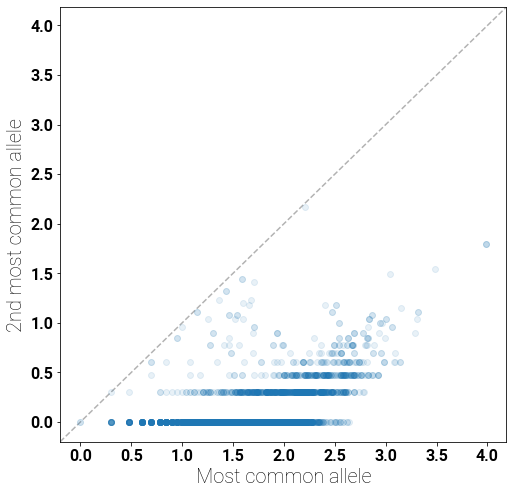

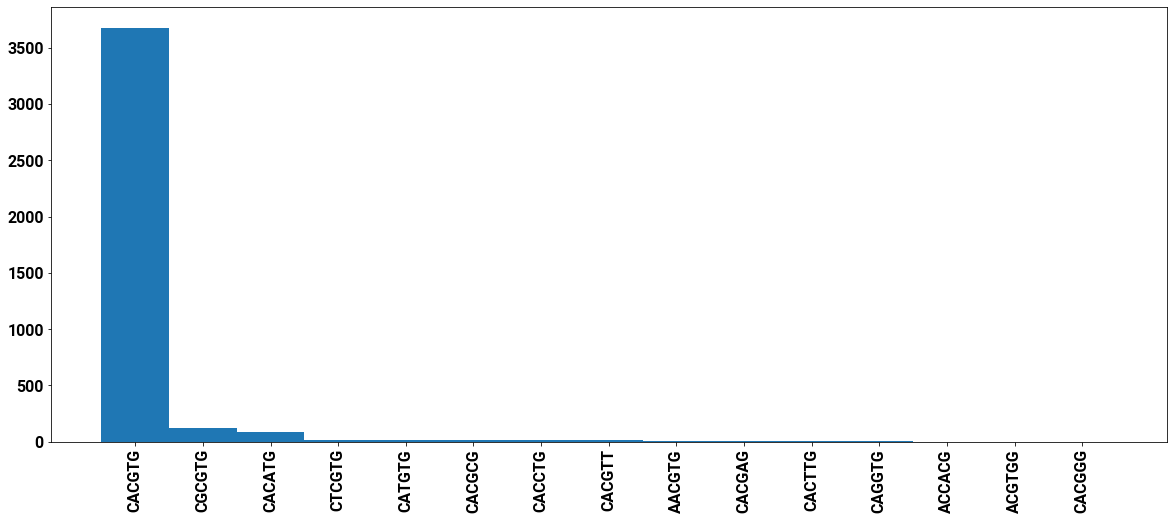

In [20]:
plot_allele_count_stats(e2f6_reads_at_max_allele_count_dicts)

340 chr1 182789715 182789723
E2F6 allele counts
Alleles: CACGTG:298, CCCGTG:13, CAGGTG:4, CACGGG:2, CGCGTG:2, GACGTG:2, CAAGTG:1, CACCCG:1, CACGAG:1, CACGTA:1, CGCGAG:1, GACGGG:1
p = 1.1102230246251565e-16
MAX allele counts
Alleles: CACGTG:175, CCCGTG:4, GACGTG:2, AACGTG:1, CACCTG:1, CACGCG:1, CACGGG:1, CAGGTG:1, CGCGTG:1, CGGGTG:1
p = 1.1102230246251565e-16

341 chr1 182789715 182789723
E2F6 allele counts
Alleles: CACGTG:298, CCCGTG:13, CAGGTG:4, CACGGG:2, CGCGTG:2, GACGTG:2, CAAGTG:1, CACCCG:1, CACGAG:1, CACGTA:1, CGCGAG:1, GACGGG:1
p = 1.1102230246251565e-16
MAX allele counts
Alleles: CACGTG:175, CCCGTG:4, GACGTG:2, AACGTG:1, CACCTG:1, CACGCG:1, CACGGG:1, CAGGTG:1, CGCGTG:1, CGGGTG:1
p = 1.1102230246251565e-16


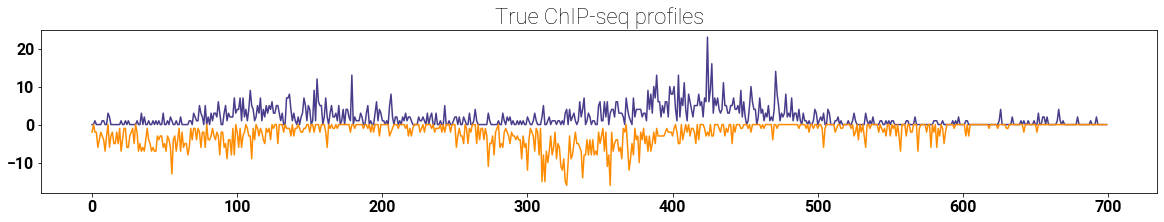

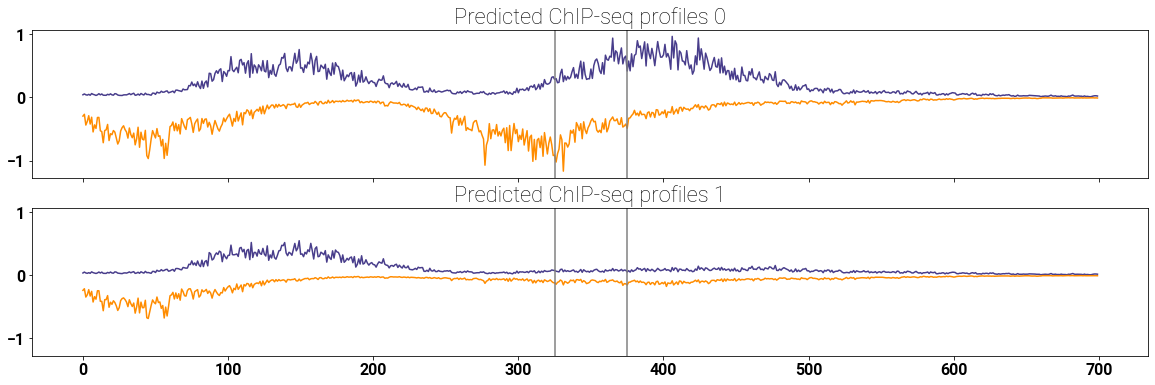

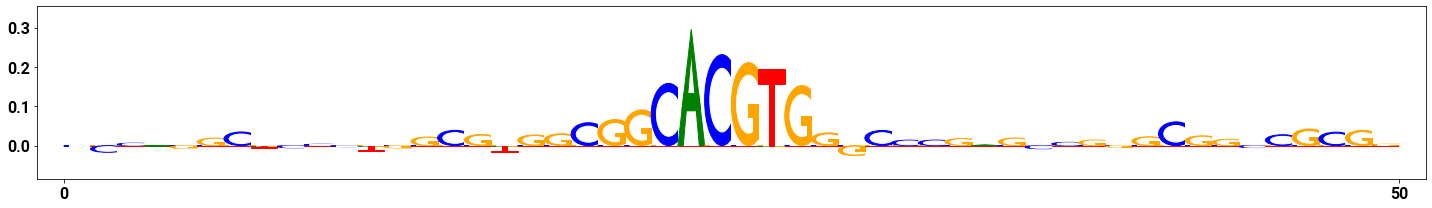

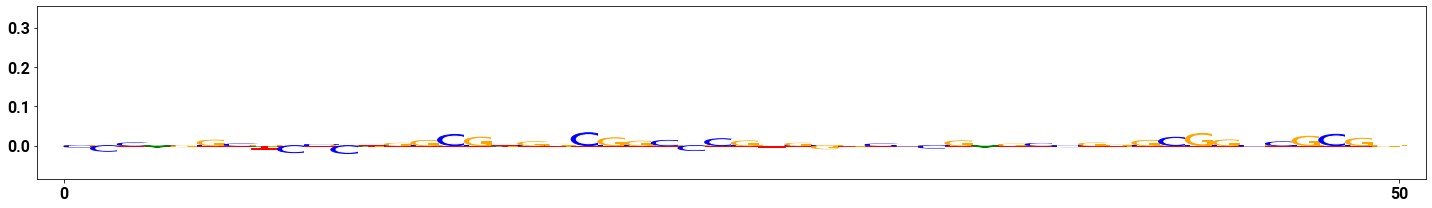

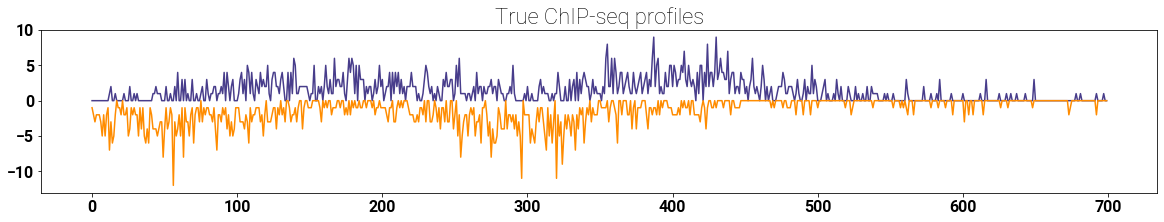

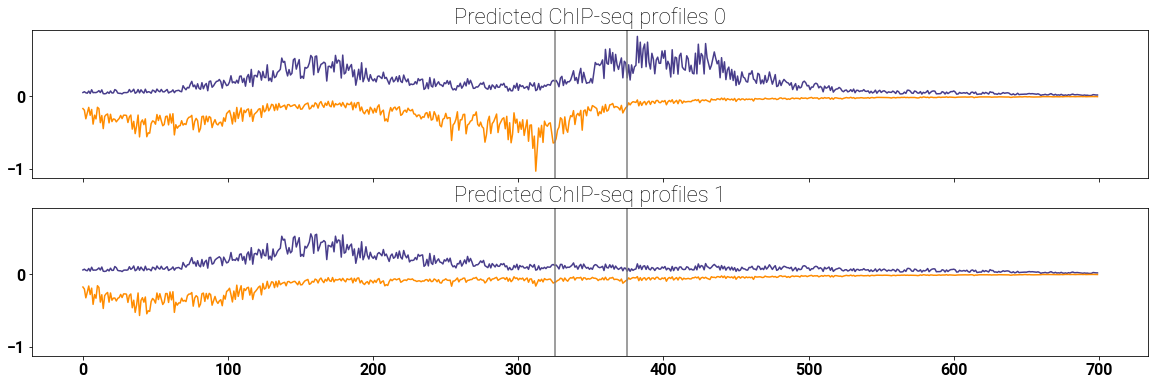

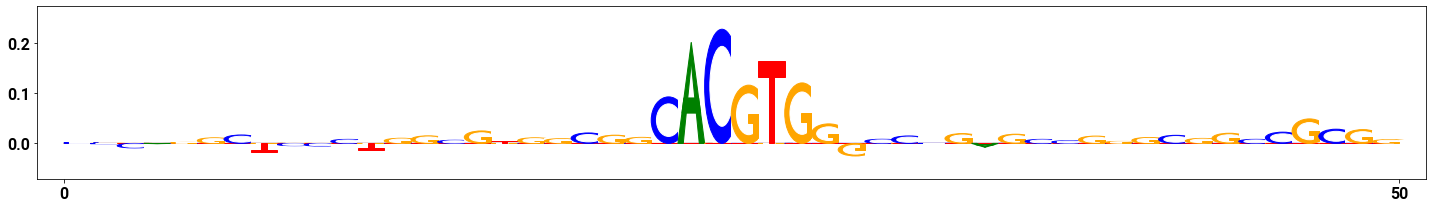

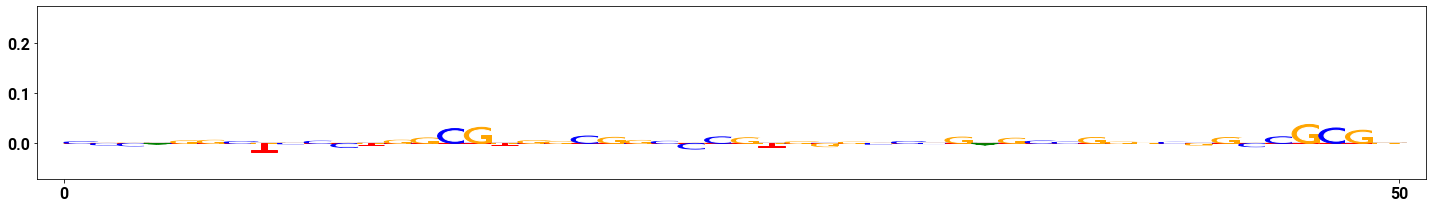

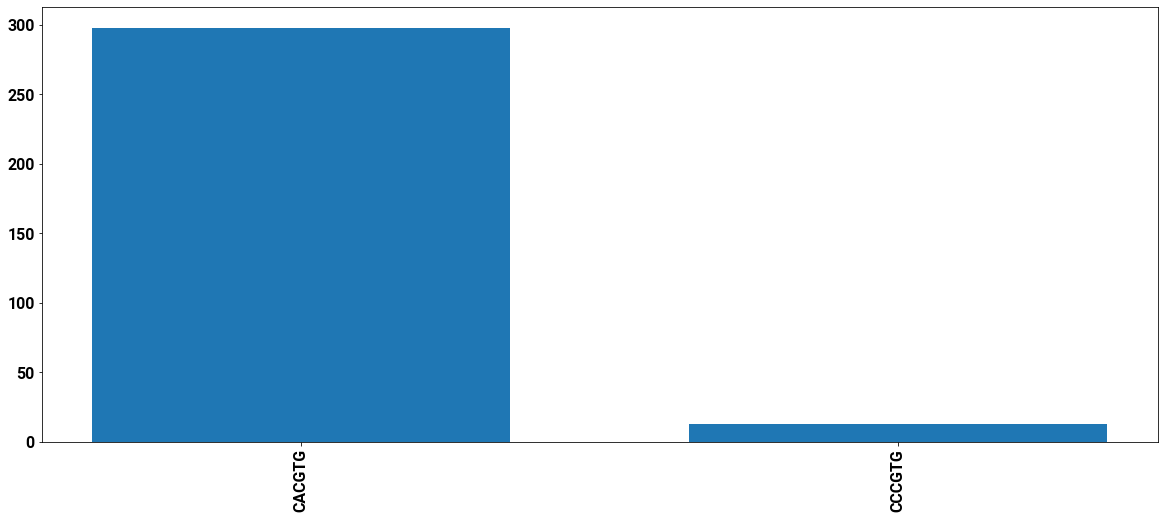

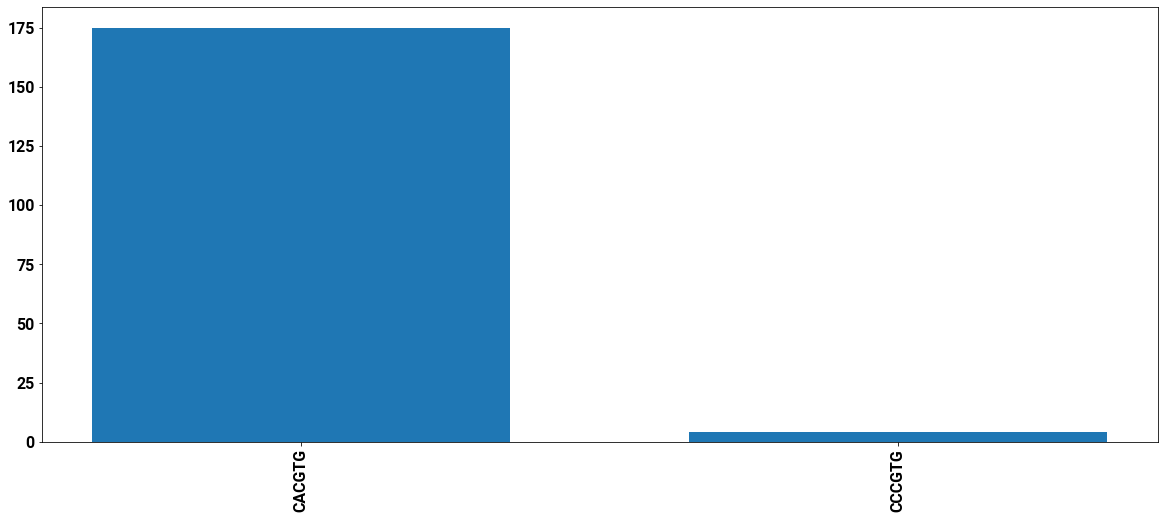


1580 chr17 36948795 36948803
E2F6 allele counts
Alleles: CACGTG:685, CACGCG:11, CACATG:1, CACGAG:1, CACGTC:1, CATGTG:1, CCCGTG:1, GACGTG:1
p = 1.1102230246251565e-16
MAX allele counts
Alleles: CACGTG:204, CACGAG:2, CACGCG:2, GACGTG:2, AACGTG:1, CACCTG:1, CACGGG:1, CAGGTG:1, CCCGTG:1
p = 1.1102230246251565e-16

1581 chr17 36948795 36948803
E2F6 allele counts
Alleles: CACGTG:685, CACGCG:11, CACATG:1, CACGAG:1, CACGTC:1, CATGTG:1, CCCGTG:1, GACGTG:1
p = 1.1102230246251565e-16
MAX allele counts
Alleles: CACGTG:204, CACGAG:2, CACGCG:2, GACGTG:2, AACGTG:1, CACCTG:1, CACGGG:1, CAGGTG:1, CCCGTG:1
p = 1.1102230246251565e-16

1582 chr17 36948795 36948803
E2F6 allele counts
Alleles: CACGTG:685, CACGCG:11, CACATG:1, CACGAG:1, CACGTC:1, CATGTG:1, CCCGTG:1, GACGTG:1
p = 1.1102230246251565e-16
MAX allele counts
Alleles: CACGTG:204, CACGAG:2, CACGCG:2, GACGTG:2, AACGTG:1, CACCTG:1, CACGGG:1, CAGGTG:1, CCCGTG:1
p = 1.1102230246251565e-16

1676 chr17 59565458 59565466
E2F6 allele counts
Alleles: CACGTG

In [21]:
# Find situations where the top counts are appropriate for analysis
for i, d in enumerate(e2f6_reads_at_max_allele_count_dicts):
    sorted_alleles = sorted(d.keys(), key=lambda k:-d[k])
    sorted_counts = [d[k] for k in sorted_alleles]
        
    # Require canonical MAX motif as top allele
    if "CACGTG" != sorted_alleles[0]:
        continue
    
    # Require both top alleles to occur enough times
    count_1, count_2 = sorted_counts[:2]
    if count_2 < 10:
        continue
        
    allele_1, allele_2 = sorted_alleles[:2]

    chrom, start, end = e2f6_reads_at_max_coords[i]
    e2f6_count_dict = e2f6_reads_at_max_allele_count_dicts[i]
    print(i, chrom, start, end)
    print("E2F6 allele counts")
    print_count_dict_stats(e2f6_count_dict)
    
    # Find matching location in MAX
    inds = np.where(
        (max_reads_at_max_coords[:, 0] == chrom) &
        (max_reads_at_max_coords[:, 1] == start) &
        (max_reads_at_max_coords[:, 2] == end)
    )[0]
    if not len(inds):
        print("No MAX reads found here")
    else:
        max_count_dict = max_reads_at_max_allele_count_dicts[inds[0]]
        print("MAX allele counts")
        print_count_dict_stats(max_count_dict)
    
    if i == 341:
        # Create the two sequences
        mid = (start + end) // 2
        seq_start = mid - (input_length // 2)
        seq_end = seq_start + input_length
        
        seq_base = get_genomic_sequence(chrom, seq_start, seq_end)
        allele_start = start - seq_start + 1  # Correct for slicing earlier
        allele_end = allele_start + len(allele_1)
        seq_1 = seq_base[:allele_start] + allele_1 + seq_base[allele_end:]
        seq_2 = seq_base[:allele_start] + allele_2 + seq_base[allele_end:]
        seqs = [seq_1, seq_2]
        
        plot_true_profiles(
            chrom, start, end, e2f6_bigwig_paths,
            save_path=os.path.join(out_path, "MAX_hit_in_E2F6_%d" % i)
        )
        plot_predictions_imp_scores(
            seqs, e2f6_model, e2f6_explainer,
            save_path=os.path.join(out_path, "MAX_hit_in_E2F6_%d" % i)
        )
        
        plot_true_profiles(
            chrom, start, end, max_bigwig_paths,
            save_path=os.path.join(out_path, "MAX_hit_in_MAX_%d" % i)
        )
        plot_predictions_imp_scores(
            seqs, max_model, max_explainer,
            save_path=os.path.join(out_path, "MAX_hit_in_MAX_%d" % i)
        )

        plot_allele_count_bars(
            e2f6_count_dict,
            save_path=os.path.join(out_path, "E2F6_with_MAX_hit_%d_counts.svg" % i)
        )
        plot_allele_count_bars(
            max_count_dict,
            save_path=os.path.join(out_path, "MAX_with_MAX_hit_%d_counts.svg" % i)
        )
        
    print()

### Reads and E2F6 motif

In [22]:
max_reads_at_e2f6_coords, max_reads_at_e2f6_allele_count_dicts = import_allele_count_dicts(
    max_reads_at_e2f6_hits_path,
    allele_extract_func=(lambda seq: seq[1:7]),
    required_alleles=["GCGGGA"],  # Require canonical E2F6 motif
    min_alleles=2  # Require multiple alleles
)
e2f6_reads_at_e2f6_coords, e2f6_reads_at_e2f6_allele_count_dicts = import_allele_count_dicts(
    e2f6_reads_at_e2f6_hits_path,
    allele_extract_func=(lambda seq: seq[1:7])
)

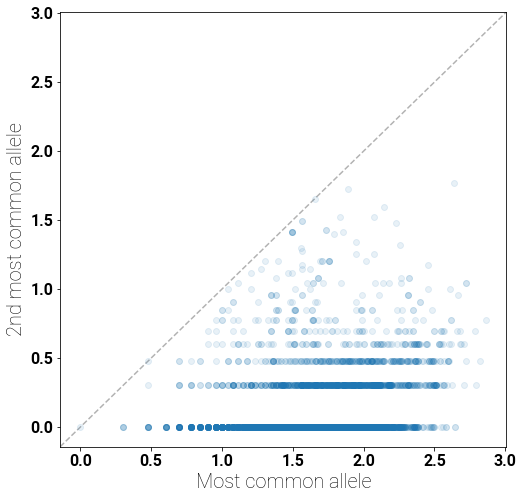

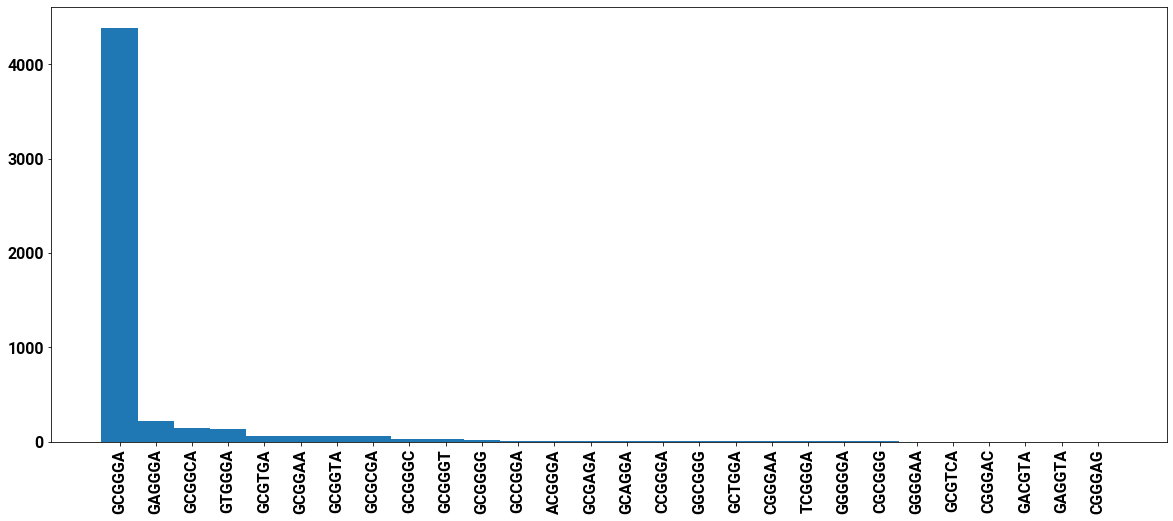

In [23]:
plot_allele_count_stats(max_reads_at_e2f6_allele_count_dicts)

1272 chr12 103930365 103930373
MAX allele counts
Alleles: GCGAGA:37, GCGGGA:31, GCGGGG:3, GCGGGC:2, GCGCGC:1
p = 0.19806242014851472
E2F6 allele counts
Alleles: GCGGGA:43, GCGAGA:28, GCGCGA:1
p = 0.02840733896641956

1273 chr12 103930365 103930373
MAX allele counts
Alleles: GCGAGA:37, GCGGGA:31, GCGGGG:3, GCGGGC:2, GCGCGC:1
p = 0.19806242014851472
E2F6 allele counts
Alleles: GCGGGA:43, GCGAGA:28, GCGCGA:1
p = 0.02840733896641956

2545 chr19 14418268 14418276
MAX allele counts
Alleles: GCGGGA:45, GCGGGG:45, GCAGGG:1, GCGGGC:1, GCGGGT:1
p = 0.45806443850564493
E2F6 allele counts
Alleles: GCGGGA:57, GCGGGG:28
p = 0.0005081104756738952
TCCCGC CCCCGC


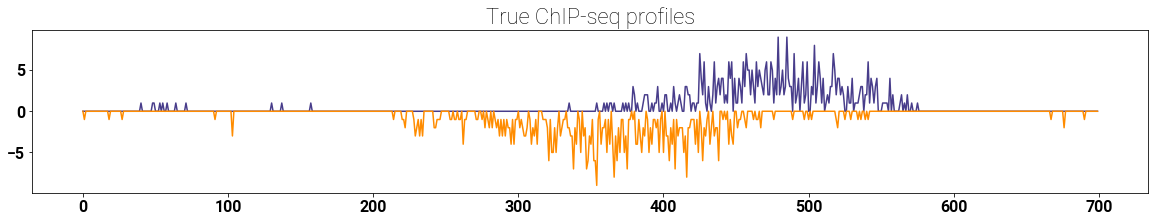

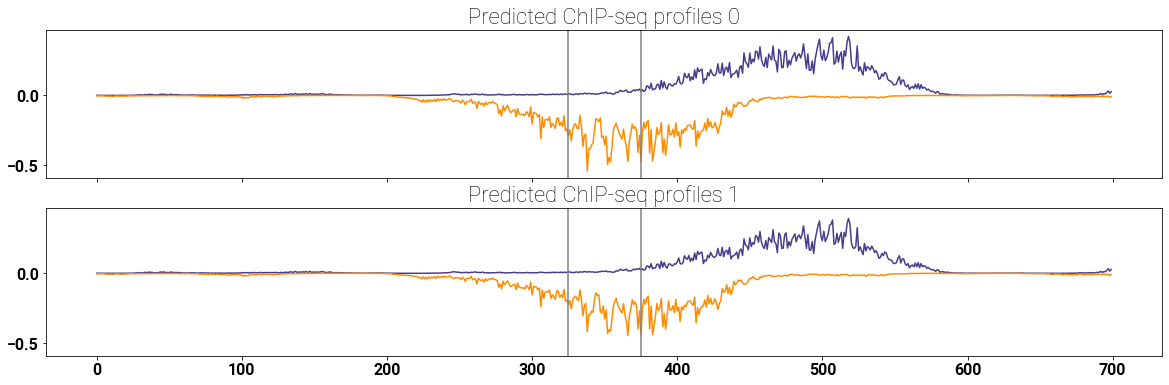

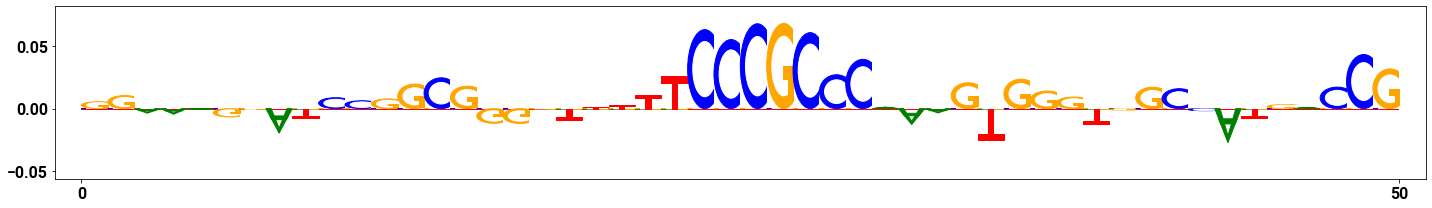

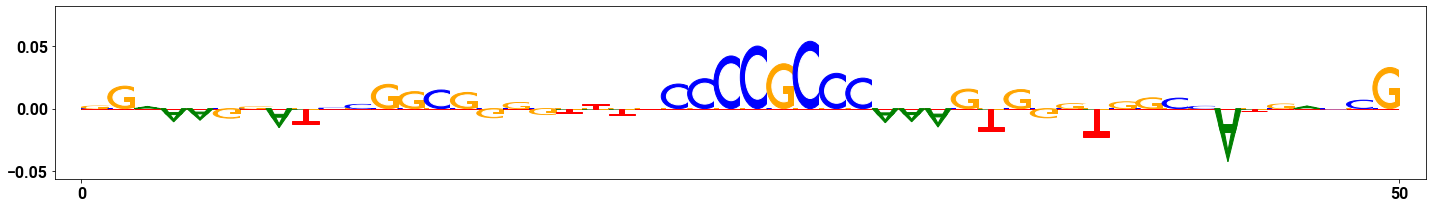

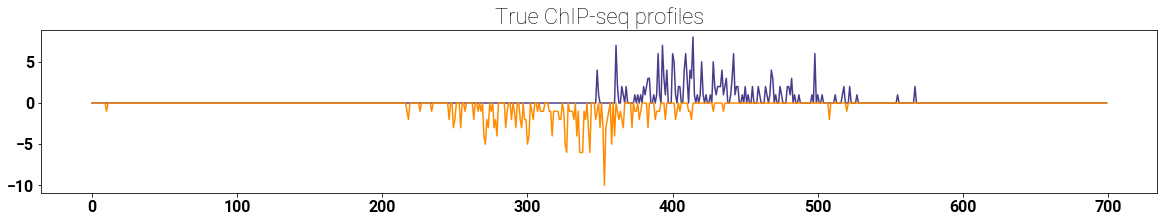

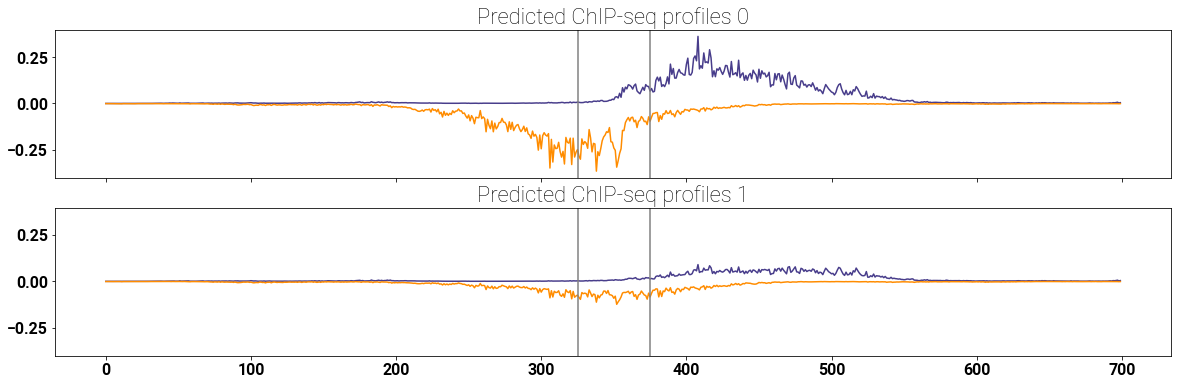

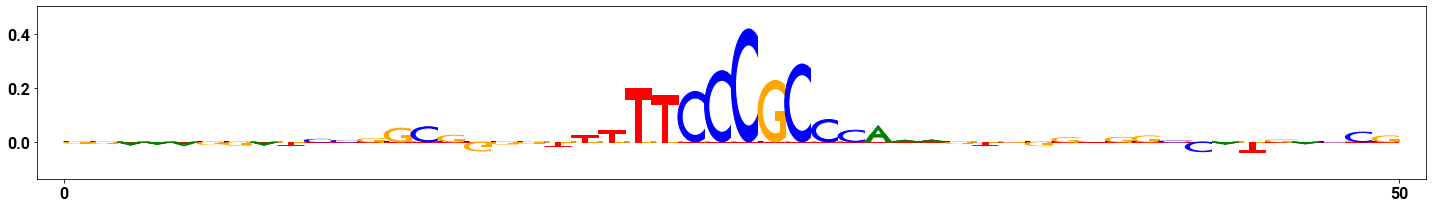

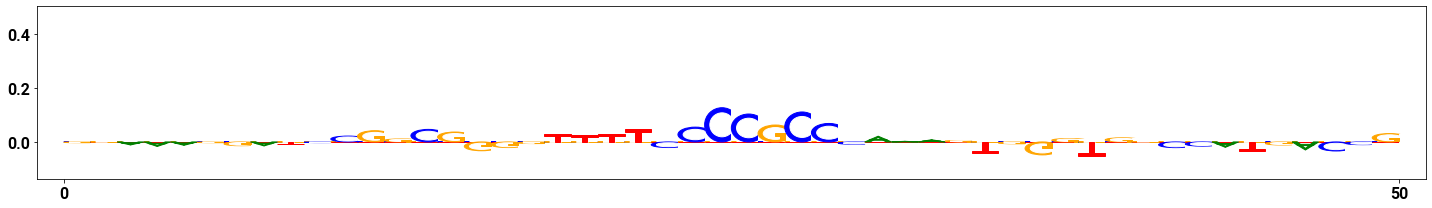

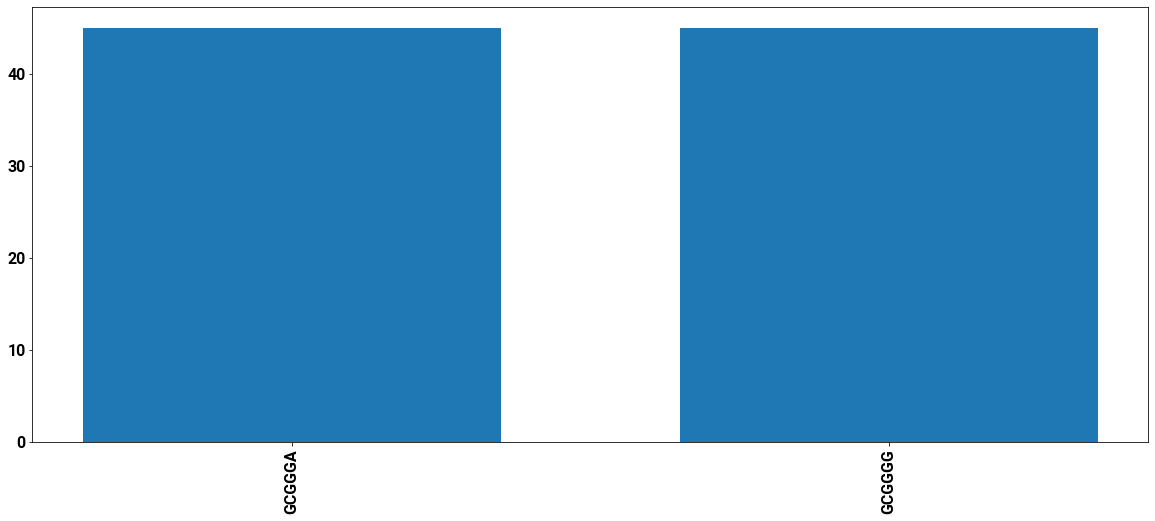

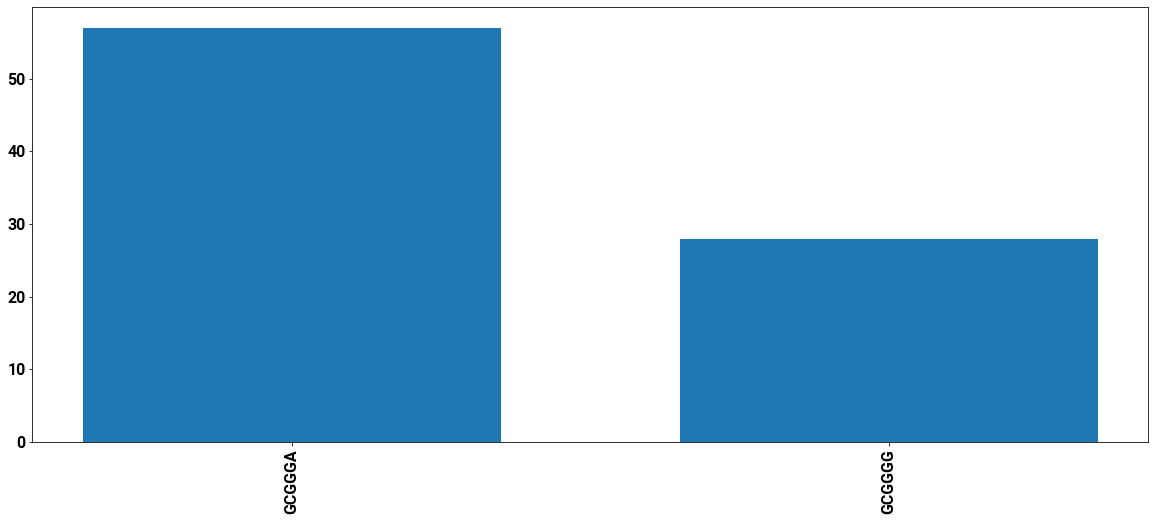


2811 chr19 56170446 56170454
MAX allele counts
Alleles: GCGGGA:11, GCAGGA:10
p = 0.33181190490722623
E2F6 allele counts
Alleles: GCGGGA:8, GCAGGA:2, GGGGGA:1
p = 0.0107421875

2920 chr2 55617759 55617767
MAX allele counts
Alleles: GGCGGG:31, GCGGGA:26, NGCGGG:1
p = 0.21352142825162745
E2F6 allele counts
Alleles: GGCGGG:12, GCGGGA:2
p = 0.00091552734375

2921 chr2 55617759 55617767
MAX allele counts
Alleles: GGCGGG:31, GCGGGA:26, NGCGGG:1
p = 0.21352142825162745
E2F6 allele counts
Alleles: GGCGGG:12, GCGGGA:2
p = 0.00091552734375

4155 chr5 173616708 173616716
MAX allele counts
Alleles: CGGGAA:13, GCGGGA:11
p = 0.27062809467315674
E2F6 allele counts
Alleles: CGGGAA:5, GCGGGA:1
p = 0.015625

5036 chr9 37422656 37422664
MAX allele counts
Alleles: GCGGGA:31, GCGGAA:26
p = 0.21352142825162745
E2F6 allele counts
Alleles: GCGGGA:33, GCGGAA:10, GAGGGA:1, GCGGGG:1
p = 8.507758730047499e-05

5037 chr9 37422656 37422664
MAX allele counts
Alleles: GCGGGA:31, GCGGAA:26
p = 0.21352142825162745
E2F6

In [24]:
# Find situations where the top counts are appropriate for analysis
for i, d in enumerate(max_reads_at_e2f6_allele_count_dicts):
    sorted_alleles = sorted(d.keys(), key=lambda k:-d[k])
    sorted_counts = [d[k] for k in sorted_alleles]
    
    # Require canonical E2F6 motif in top 2 alleles
    if "GCGGGA" not in sorted_alleles[:2]:
        continue
    
    # Require both top alleles to occur enough times
    count_1, count_2 = sorted_counts[:2]
    if count_2 < 10:
        continue
    
    # Require similar counts for top two alleles
    if count_1 / count_2 > 1.2:
        continue
        
    allele_1, allele_2 = sorted_alleles[:2]

    chrom, start, end = max_reads_at_e2f6_coords[i]
    max_count_dict = max_reads_at_e2f6_allele_count_dicts[i]
    print(i, chrom, start, end)
    print("MAX allele counts")
    print_count_dict_stats(max_count_dict)
    
    # Find matching location in E2F6
    inds = np.where(
        (e2f6_reads_at_e2f6_coords[:, 0] == chrom) &
        (e2f6_reads_at_e2f6_coords[:, 1] == start) &
        (e2f6_reads_at_e2f6_coords[:, 2] == end)
    )[0]
    if not len(inds):
        print("No E2F6 reads found here")
    else:
        e2f6_count_dict = e2f6_reads_at_e2f6_allele_count_dicts[inds[0]]
        print("E2F6 allele counts")
        print_count_dict_stats(e2f6_count_dict)
    
    # if i == 5036 or i == 2545 or i == 1272:
    if i == 2545:
        # Create the two sequences
        mid = (start + end) // 2
        seq_start = mid - (input_length // 2)
        seq_end = seq_start + input_length
        
        seq_base = get_genomic_sequence(chrom, seq_start, seq_end)
        allele_start = start - seq_start + 1  # Correct for slicing earlier
        allele_end = allele_start + len(allele_1)
        seq_1 = seq_base[:allele_start] + revcomp_seq(allele_1) + seq_base[allele_end:]
        seq_2 = seq_base[:allele_start] + revcomp_seq(allele_2) + seq_base[allele_end:]
        seqs = [seq_1, seq_2]
        
        print(seq_1[allele_start:allele_end], seq_2[allele_start:allele_end])
        
        plot_true_profiles(
            chrom, start, end, max_bigwig_paths,
            save_path=os.path.join(out_path, "E2F6_hit_in_MAX_%d" % i)
        )
        plot_predictions_imp_scores(
            seqs, max_model, max_explainer,
            save_path=os.path.join(out_path, "E2F6_hit_in_MAX_%d" % i)
        )
        
        plot_true_profiles(
            chrom, start, end, e2f6_bigwig_paths,
            save_path=os.path.join(out_path, "E2F6_hit_in_E2F6_%d" % i)
        )
        plot_predictions_imp_scores(
            seqs, e2f6_model, e2f6_explainer,
            save_path=os.path.join(out_path, "E2F6_hit_in_E2F6_%d" % i)
        )
        
        plot_allele_count_bars(
            max_count_dict,
            save_path=os.path.join(out_path, "MAX_with_E2F6_hit_%d_counts.svg" % i)
        )
        plot_allele_count_bars(
            e2f6_count_dict,
            save_path=os.path.join(out_path, "E2F6_with_E2F6_hit_%d_counts.svg" % i)
        )
        
    print()